In [2]:
import sys

from argparse import ArgumentParser
import numpy
import numpy as np
import scipy.io
from pyDOE import lhs
import torch
from torch import Tensor, ones, stack, load
from torch.autograd import grad
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm
import wandb 
import time

In [4]:
sys.path.append("/content/drive/MyDrive/NeuralSolvers")  # PINNFramework etc.
import PINNFramework as pf

Was not able to import Horovod. Thus Horovod support is not enabled


In [5]:
class BoundaryConditionDatasetlb(Dataset):
    
    def __init__(self, nb, lb, ub):
        """
        Constructor of the lower boundary condition dataset

        Args:
          nb (int)
          lb (numpy.ndarray)
          ub (numpy.ndarray)
        """
        super(type(self)).__init__()
        
        # maximum of the time domain
        max_t = 2
        t = np.linspace(0,max_t,200).flatten()[:, None]
        idx_t = np.random.choice(t.shape[0], nb, replace=False)
        tb = t[idx_t, :]
        self.x_lb = np.concatenate((0 * tb + lb[0], tb), 1)  # (lb[0], tb)
        
    def __getitem__(self, idx):
        """
        Returns data for initial state
        """
        return Tensor(self.x_lb).float()
    def __len__(self):
        """
        There exists no batch processing. So the size is 1
        """
        return 1

In [6]:
class BoundaryConditionDatasetub(Dataset):

    def __init__(self, nb, lb, ub):
        """
        Constructor of the upper boundary condition dataset

        Args:
          nb (int)
          lb (numpy.ndarray)
          ub (numpy.ndarray)
        """
        super(type(self)).__init__()
    
        # maximum of the time domain
        max_t = 2
        t = np.linspace(0,max_t,200).flatten()[:, None]
        idx_t = np.random.choice(t.shape[0], nb, replace=False)
        tb = t[idx_t, :]
        self.x_ub = np.concatenate((0 * tb + ub[0], tb), 1)  # (ub[0], tb)

    def __getitem__(self, idx):
        """
        Returns data for initial state
        """
        return Tensor(self.x_ub).float()
    def __len__(self):
        """
        There exists no batch processing. So the size is 1
        """
        return 1

In [7]:
class InitialConditionDataset(Dataset):

    def __init__(self, n0):
        """
        Constructor of the inital condition dataset

        Args:
          n0 (int)
        """
        super(type(self)).__init__()

        L=1               
        c=1               
        alpha = (c*np.pi/L)**2
        max_t = 10
        max_x = L

        t = np.zeros(200).flatten()[:, None]
        x = np.linspace(0,max_x,200).flatten()[:, None]

        U=(np.exp(-(alpha)*t))*np.sin(np.pi*x/L)
        u=U.flatten()[:, None]

        idx_x = np.random.choice(x.shape[0], n0, replace=False)
        self.x = x[idx_x,:]
        self.u = u[idx_x,:]
        self.t = t[idx_x,:]

    def __len__(self):
        """
        There exists no batch processing. So the size is 1
        """
        return 1

    def __getitem__(self, idx):
        x = np.concatenate([self.x, self.t], axis=1)
        y = np.concatenate([self.u], axis=1)
        return Tensor(x).float(), Tensor(y).float()

In [8]:
if __name__ == "__main__":
    
    # Domain bounds
    lb = np.array([0, 0.0])
    ub = np.array([1.0, 2.0])
    
    # initial condition
    ic_dataset = InitialConditionDataset(n0=50)
    initial_condition = pf.InitialCondition(ic_dataset, name='Initial condition')
    
    # boundary conditions
    bc_datasetlb = BoundaryConditionDatasetlb(nb=50, lb=lb, ub=ub)
    bc_datasetub = BoundaryConditionDatasetub(nb=50, lb=lb, ub=ub)
    
    # Function for dirichlet boundary condition
    def func(x):
        return  torch.zeros_like(x)[:,0].reshape(-1,1)
    
    dirichlet_bc_u_lb = pf.DirichletBC(func, bc_datasetlb, name= 'ulb dirichlet boundary condition')
    dirichlet_bc_u_ub = pf.DirichletBC(func, bc_datasetub, name= 'uub dirichlet boundary condition')

    # PDE
    #pde_dataset = PDEDataset(10000, lb, ub)

    def heat1d(x, u):

        grads = ones(u.shape, device=u.device) # move to the same device as prediction
        grad_u = grad(u, x, create_graph=True, grad_outputs=grads)[0]

        #print('grad u', grad_u.shape)

        # calculate first order derivatives
        u_x = grad_u[:, 0]
        u_t = grad_u[:, 1]

        #print('u_t', u_t.shape)
      
        # calculate second order derivatives
        grads = ones(u_x.shape, device=u.device)  # move to the same device as prediction
        grad_u_x = grad(u_x, x, create_graph=True, grad_outputs=grads)[0]
        u_xx = grad_u_x[:, 0]

        # reshape for correct behavior of the optimizer
        u_x = u_x.reshape(-1, 1)
        u_t = u_t.reshape(-1, 1)
        u_xx = u_xx.reshape(-1, 1)
        
        # residual function
        f = u_t - 1 * u_xx

        return f
    
    geometry = pf.Geometry(lb, ub)
    sampler = pf.Sampler(geometry,num_points=20000, sampler ='lhs')
    pde_loss = pf.PDELossAdaptive(geometry, heat1d, name='1D Heat', sampler= sampler)
    #pde_loss = pf.PDELoss(pde_dataset, heat1d, name='1D Heat', weight = 1)
    
    # create model
    model = pf.models.MLP(input_size=2,
                          output_size=1,
                          hidden_size=100,
                          num_hidden=4,
                          lb=lb,
                          ub=ub)
    
    # create PINN instance
    pinn = pf.PINN(model, 2, 1, pde_loss, initial_condition, [dirichlet_bc_u_lb,dirichlet_bc_u_ub], use_gpu=True)
    
    #logger = pf.WandbLogger(args={},project="1D Heat equation pinn")
    
    # train pinn
    begin_adaptive = time.time()
    pinn.fit(10000,learning_rate=1e-3, checkpoint_path='checkpoint.pt', restart=True,lbfgs_finetuning=False, pretraining = True)
    pinn.load_model('best_model_pinn.pt')
    end_adaptive = time.time()



Streaming output truncated to the last 5000 lines.
x tensor([[0.4786, 0.7891],
        [0.9587, 1.9928],
        [0.4959, 1.8811],
        ...,
        [0.2561, 1.4837],
        [0.8730, 0.7236],
        [0.3882, 0.3195]], device='cuda:0')
PINN Loss 0.00020917630172334611 Epoch 9376 from 10000
x tensor([[0.4786, 0.7891],
        [0.9587, 1.9928],
        [0.4959, 1.8811],
        ...,
        [0.2561, 1.4837],
        [0.8730, 0.7236],
        [0.3882, 0.3195]], device='cuda:0')
PINN Loss 0.000239828834310174 Epoch 9377 from 10000
x tensor([[0.4786, 0.7891],
        [0.9587, 1.9928],
        [0.4959, 1.8811],
        ...,
        [0.2561, 1.4837],
        [0.8730, 0.7236],
        [0.3882, 0.3195]], device='cuda:0')
PINN Loss 8.591695950599387e-05 Epoch 9378 from 10000
x tensor([[0.4786, 0.7891],
        [0.9587, 1.9928],
        [0.4959, 1.8811],
        ...,
        [0.2561, 1.4837],
        [0.8730, 0.7236],
        [0.3882, 0.3195]], device='cuda:0')
PINN Loss 0.0001342529285466298

In [9]:
print("time adaptive:", end_adaptive - begin_adaptive)

time adaptive: 1882.2350678443909


In [10]:
# Use cuda if it is available, else use the cpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


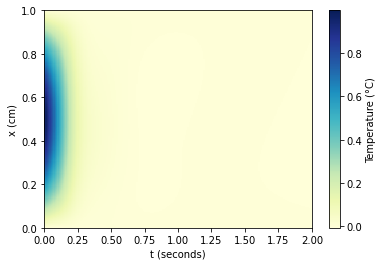

In [11]:
#Plotting
max_t = 2
max_x = 1

t = np.linspace(0,max_t,200).flatten()[:, None]
x = np.linspace(0,max_x,200).flatten()[:, None]
X, T = np.meshgrid(x, t)

X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
pred = pinn(Tensor(X_star).to(device))
pred_u = pred.detach().cpu().numpy()

H_pred = pred_u.reshape(X.shape)
plt.imshow(H_pred.T, interpolation='nearest', cmap='YlGnBu',
            extent= [lb[1], ub[1], lb[0], ub[0]],
            origin='lower', aspect='auto')
plt.ylabel('x (cm)')
plt.xlabel('t (seconds)')
plt.colorbar().set_label('Temperature (°C)')
plt.show()

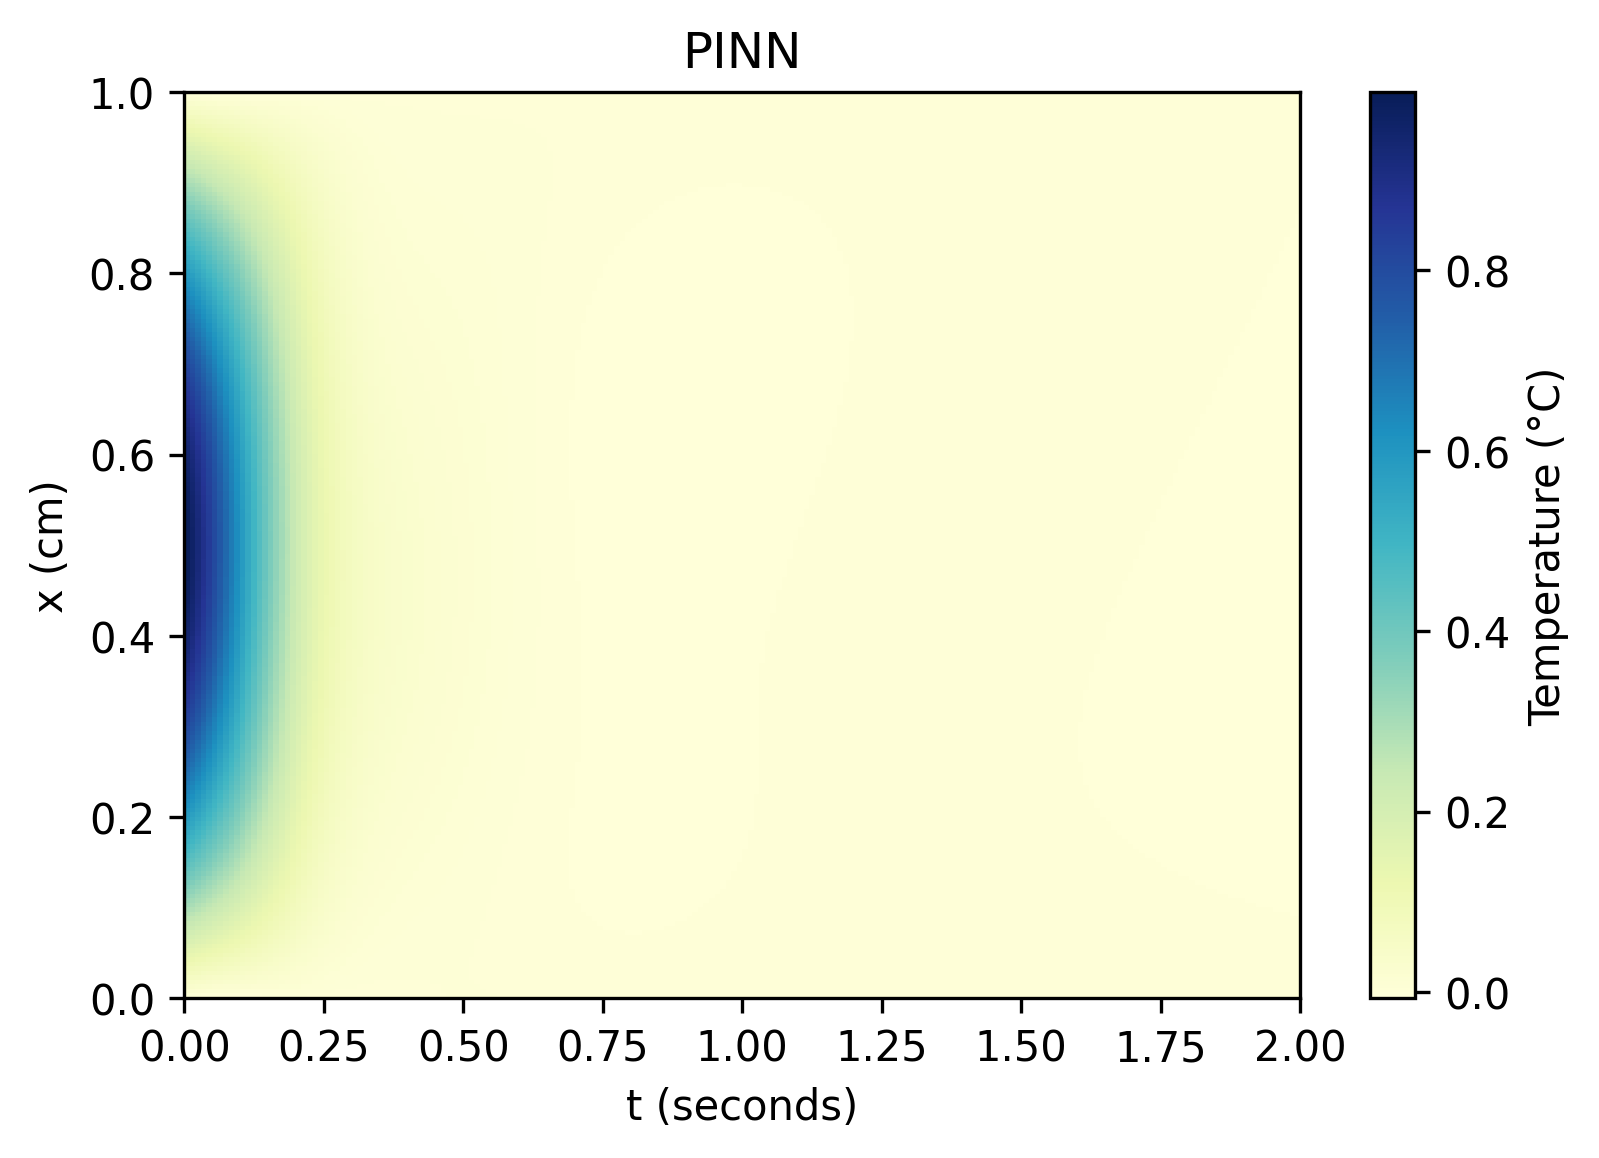

In [12]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

#Plotting
max_t = 2
max_x = 1

t = np.linspace(0,max_t,200).flatten()[:, None]
x = np.linspace(0,max_x,200).flatten()[:, None]
X, T = np.meshgrid(x, t)

X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
pred = pinn(Tensor(X_star).to(device))
pred_u = pred.detach().cpu().numpy()

H_pred = pred_u.reshape(X.shape)
plt.imshow(H_pred.T, interpolation='nearest', cmap='YlGnBu',
            extent= [lb[1], ub[1], lb[0], ub[0]],
            origin='lower', aspect='auto')
plt.title('PINN')
plt.ylabel('x (cm)')
plt.xlabel('t (seconds)')
plt.colorbar().set_label('Temperature (°C)')
plt.show()

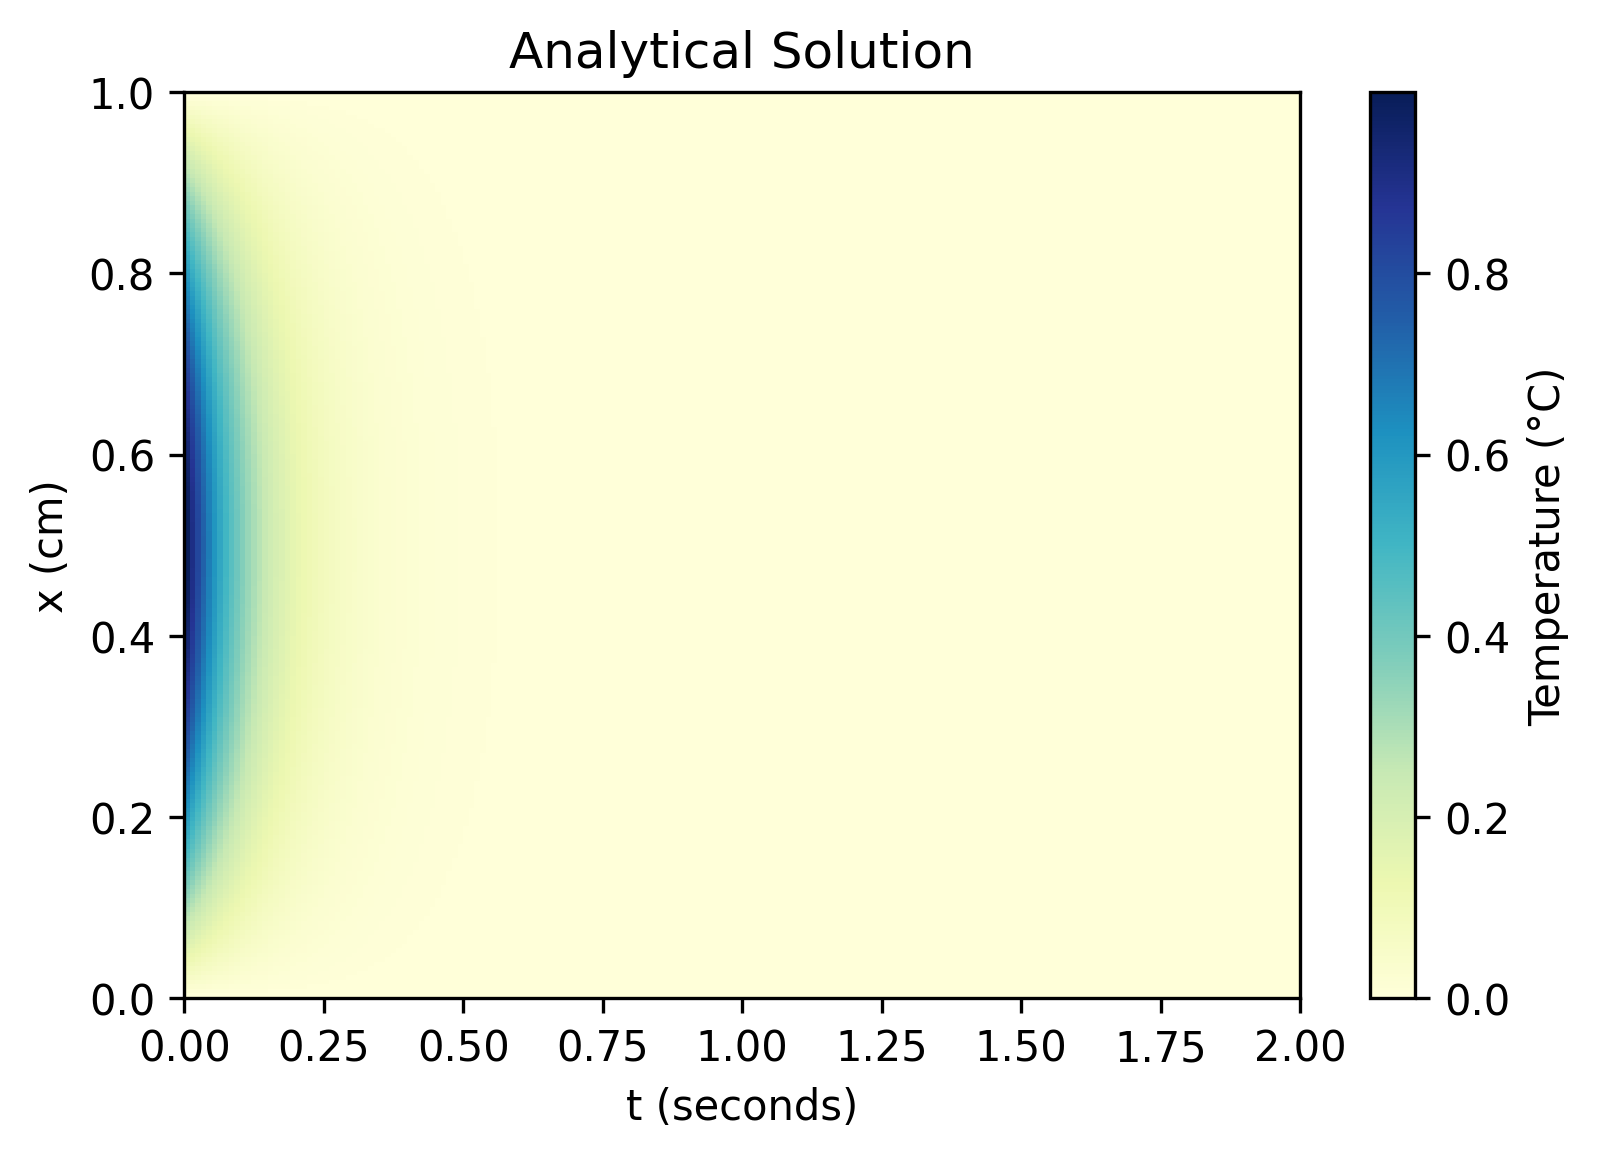

In [13]:
# Analytical Solution

L=1
c=1
max_t = 2
alpha = (c*np.pi/L)**2

# Domain bounds
lb = np.array([0, 0.0])
ub = np.array([L, max_t])

t = np.linspace(0, max_t, 200)
x = np.linspace(0, L, 200)
X, T = np.meshgrid(x, t)
X = X.reshape(-1,1)
T = T.reshape(-1,1)

U=(np.exp(-alpha*T))*np.sin(np.pi*X/L)
U = U.reshape(200,200)

plt.imshow(U.T, interpolation='nearest', cmap='YlGnBu',
                extent= [lb[1], ub[1], lb[0], ub[0]],
                origin='lower', aspect='auto')

plt.title('Analytical Solution')
plt.ylabel('x (cm)')
plt.xlabel('t (seconds)')
plt.axis()
plt.colorbar().set_label('Temperature (°C)')
plt.show()

Text(0.5, 1.0, 'Analytical Solution')

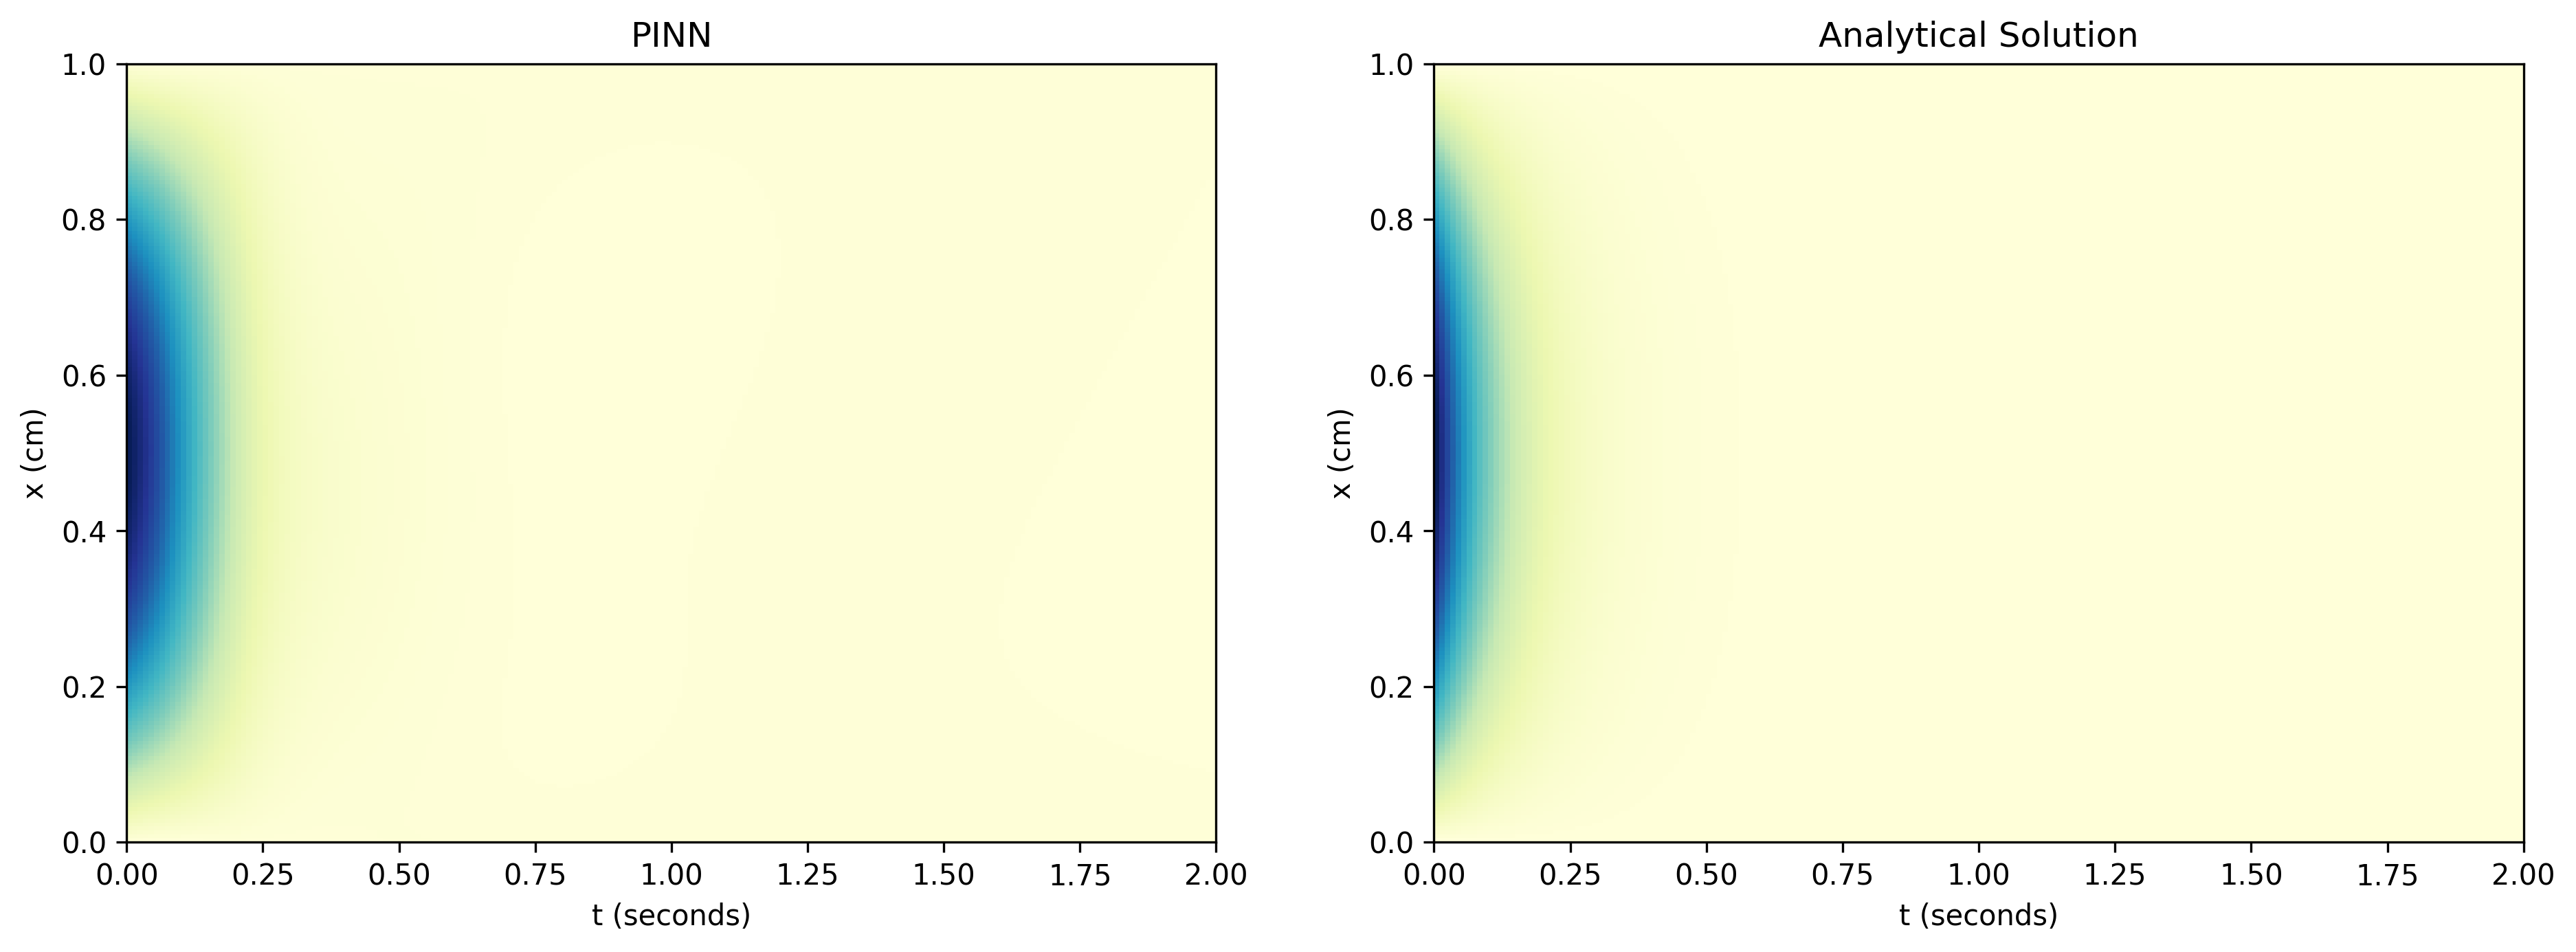

In [14]:
#plt.figure(figsize = (12, 8))
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
#plt.subplot(2, 1, 1)
axes[0].imshow(H_pred.T, interpolation='nearest', cmap='YlGnBu',
            extent= [lb[1], ub[1], lb[0], ub[0]],
            origin='lower', aspect='auto')
#axes[0].plt.ylabel('x (cm)')
#plt.xlabel('t (seconds)')
#plt.colorbar().set_label('Temperature (°C)')
#plt.show()

#plt.subplot(2, 1, 2)

#plt.figure(figsize = (12, 8))
axes[1].imshow(U.T, interpolation='nearest', cmap='YlGnBu',
                extent= [lb[1], ub[1], lb[0], ub[0]],
                origin='lower', aspect='auto')

#plt.ylabel('x (cm)')
#plt.xlabel('t (seconds)')
#plt.axis()
#plt.colorbar().set_label('Temperature (°C)')
#plt.show()
axes[0].set_xlabel('t (seconds)')
axes[1].set_xlabel('t (seconds)')

#fig.colorbar(H_pred.T, ax=axes[0])

axes[0].set_ylabel('x (cm)')
axes[1].set_ylabel('x (cm)')

axes[0].set_title('PINN')
axes[1].set_title('Analytical Solution')

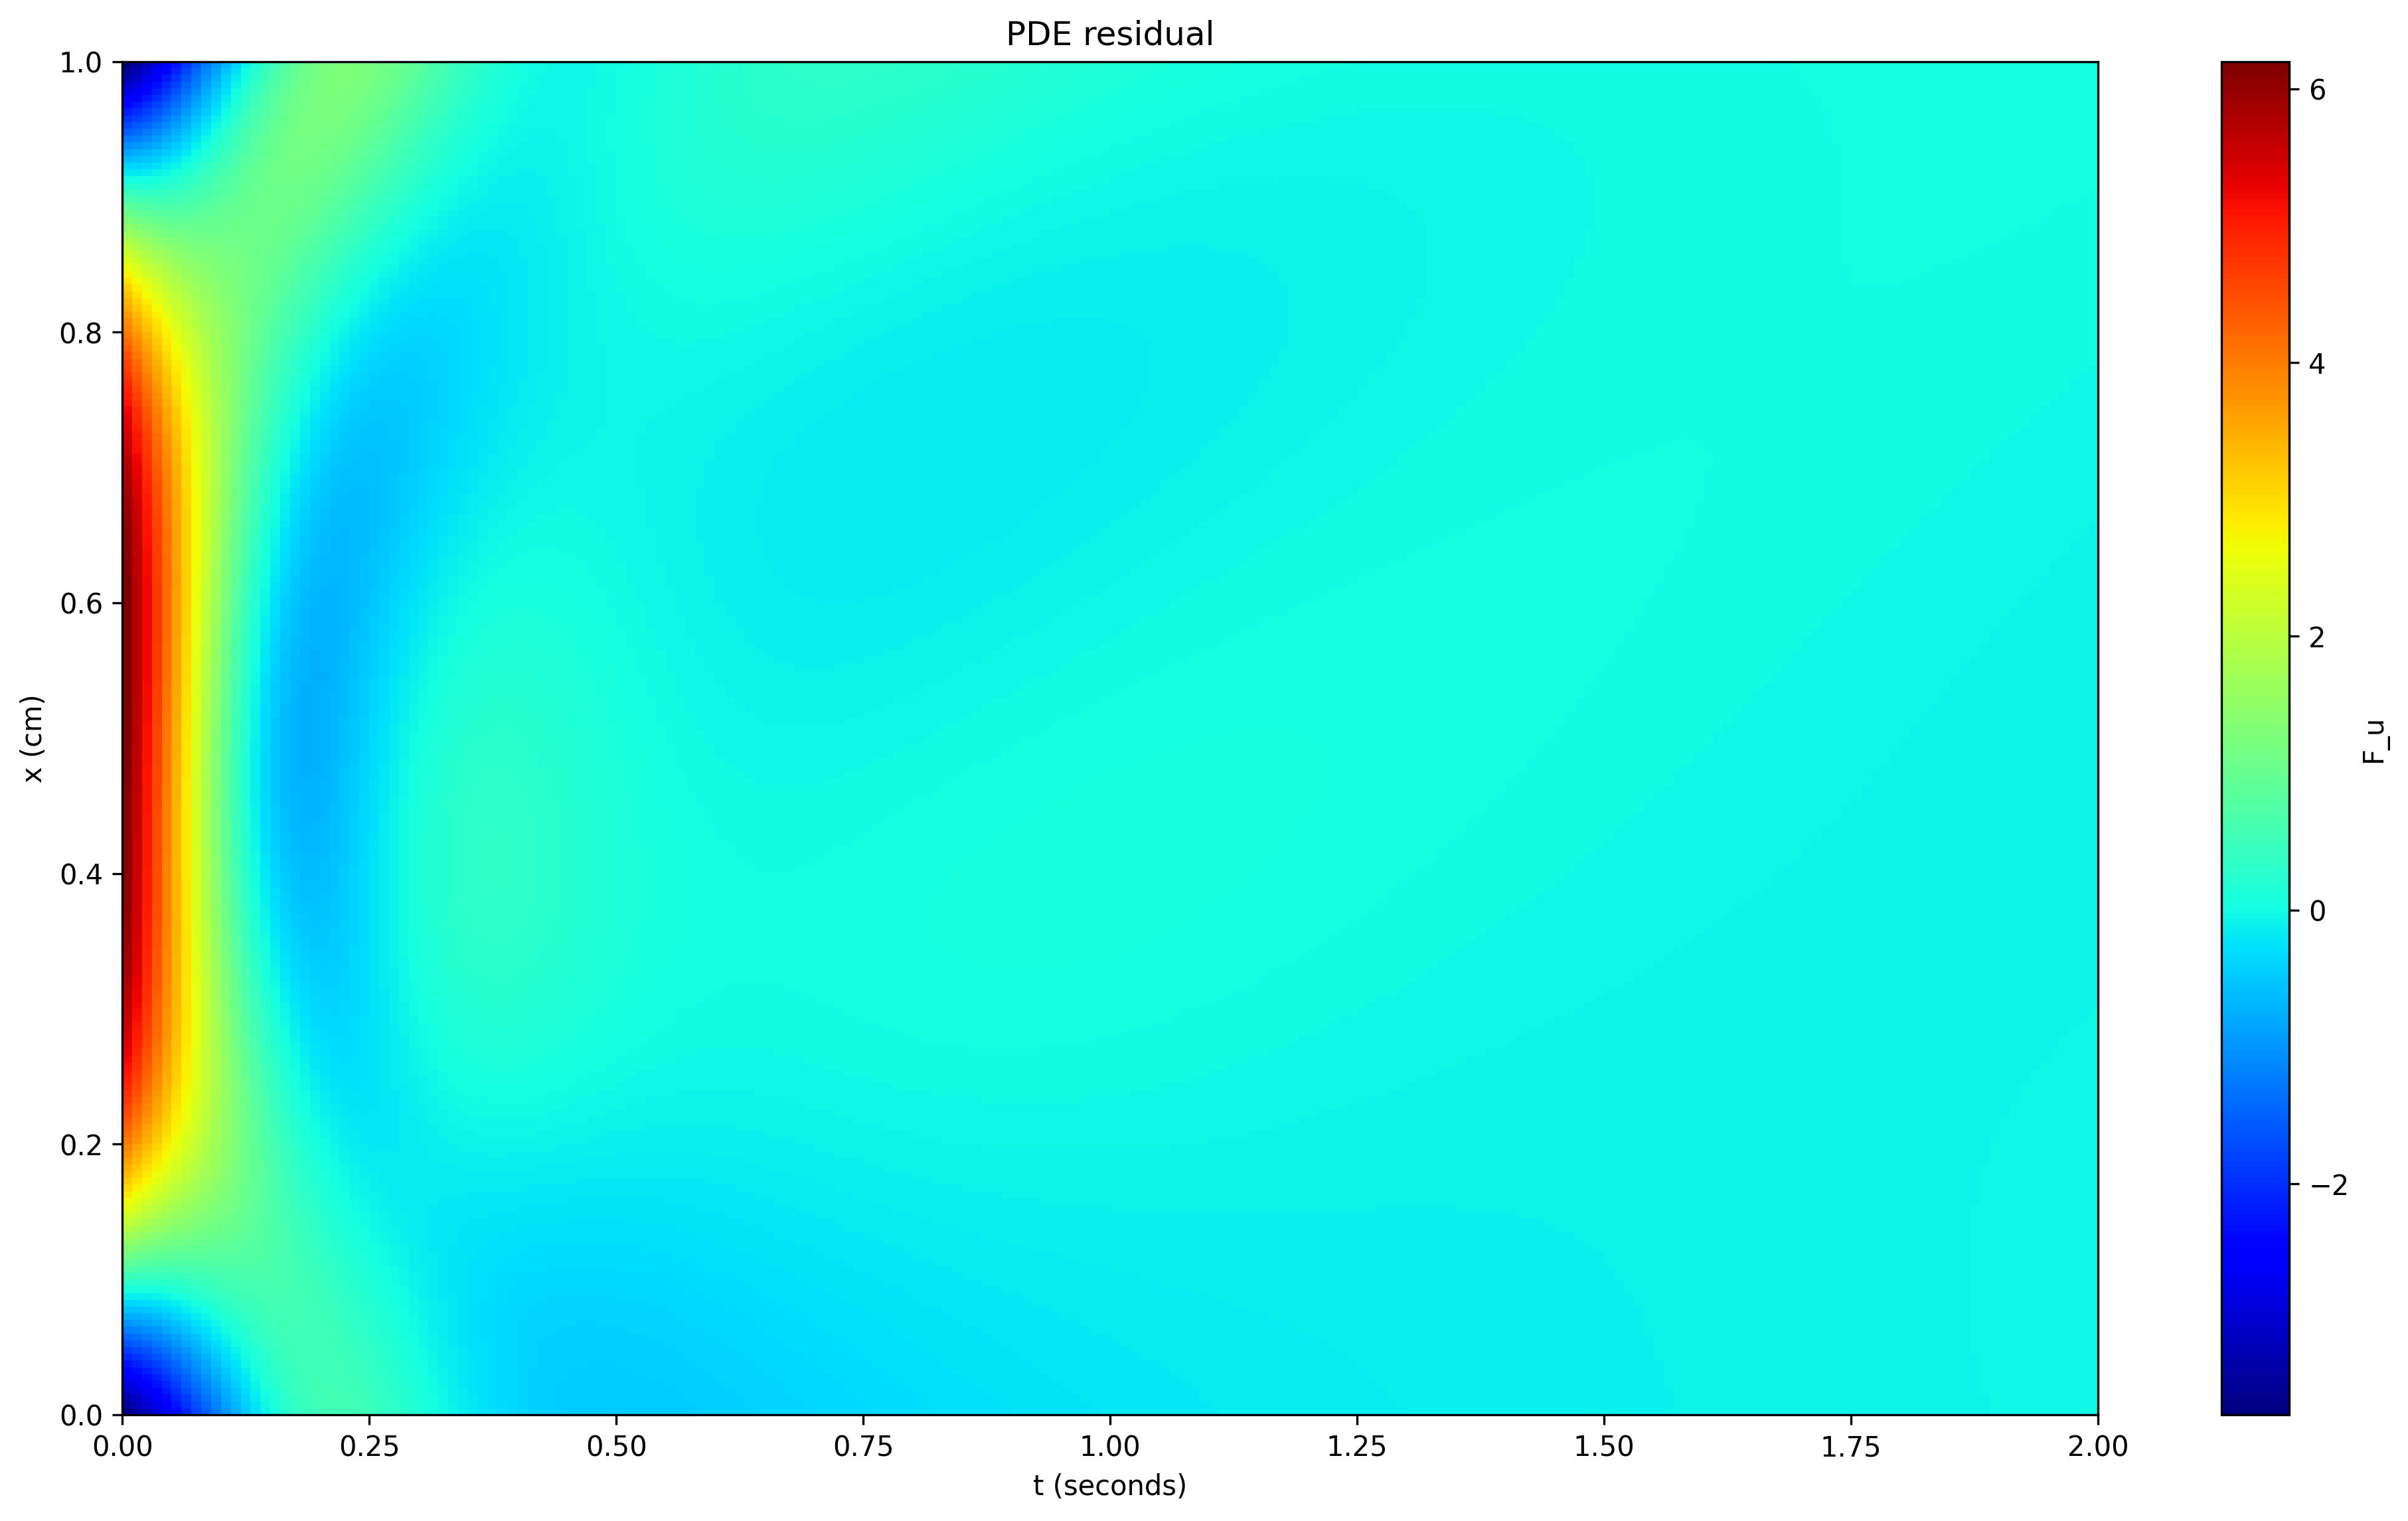

In [15]:
#PDEloss plot
L=1
c=1
max_t = 2
alpha = (c*np.pi/L)**2

# Domain bounds
lb = np.array([0, 0.0])
ub = np.array([L, max_t])

t = np.linspace(0, max_t, 200)
x = np.linspace(0, L, 200)
X, T = np.meshgrid(x, t)
X = X.reshape(-1,1)
T = T.reshape(-1,1)

X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))

X_star = torch.tensor(X_star).float().to(device)
X_star.requires_grad = True
plt.figure(figsize=(16,9))
pred = pinn(X_star)

F_u = heat1d(X_star, pred)
F_u = F_u.detach().cpu().numpy()
F_u = F_u.reshape(200,200)


plt.title('PDE residual')
plt.ylabel('x (cm)')
plt.xlabel('t (seconds)')
plt.imshow(F_u.T, cmap='jet', aspect='auto', extent= [lb[1], ub[1], lb[0], ub[0]],
                origin='lower')
plt.colorbar().set_label('F_u')

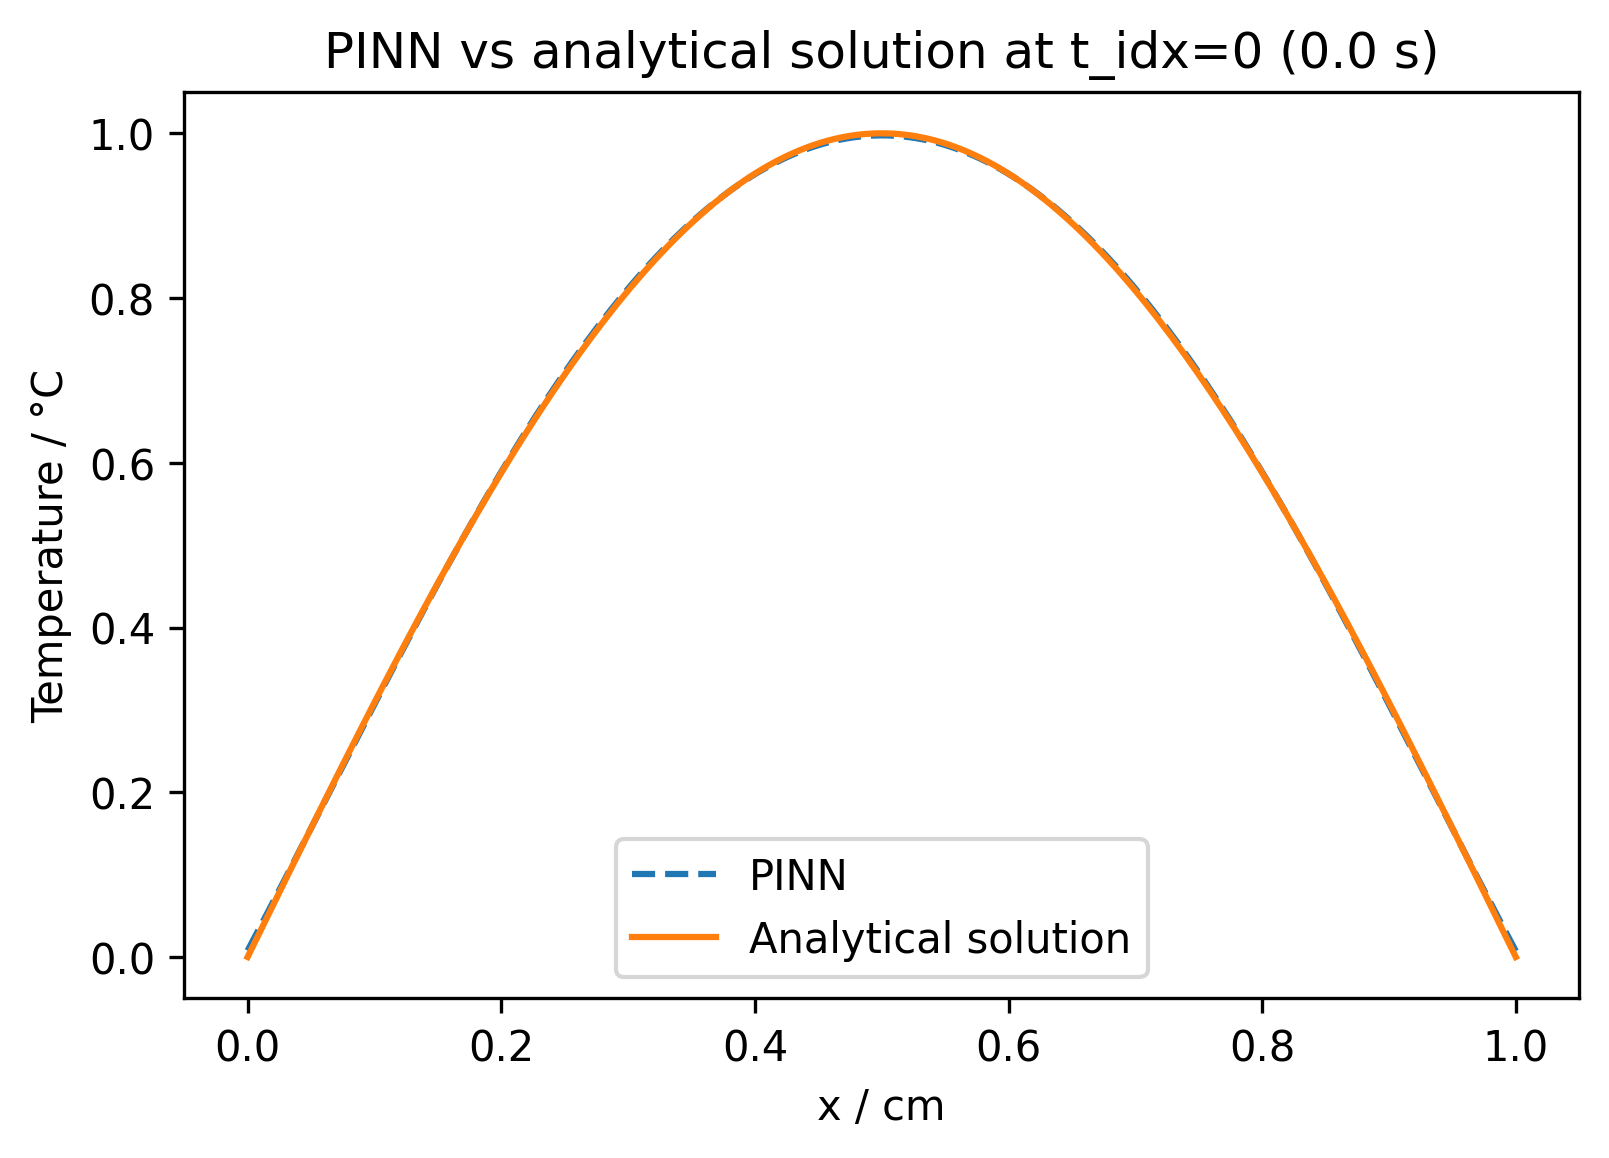

MAE: 0.0017574710947952743
MSE: 4.416600347253468e-06
Relative error (%): 0.2979528257576258


In [16]:
# PINN vs analytical solution at t_idx=0
plt.plot(x, H_pred[0,:], '--')
plt.plot(x, U[0,:], '-')
plt.title('PINN vs analytical solution at t_idx=0 ({} s)'.format(t[0]))
plt.legend(['PINN', 'Analytical solution'])
plt.xlabel('x / cm')
plt.ylabel('Temperature / °C')
plt.show()

mae = np.sum(np.abs(H_pred[0,:]- U[0,:]).mean(axis=None))
print('MAE:', mae)

mse = ((U[0,:] - H_pred[0,:])**2).mean(axis=None)
print('MSE:', mse)

rel_error = np.linalg.norm(H_pred[0,:]- U[0,:]) / np.linalg.norm(U[0,:])
print('Relative error (%):', rel_error*100)



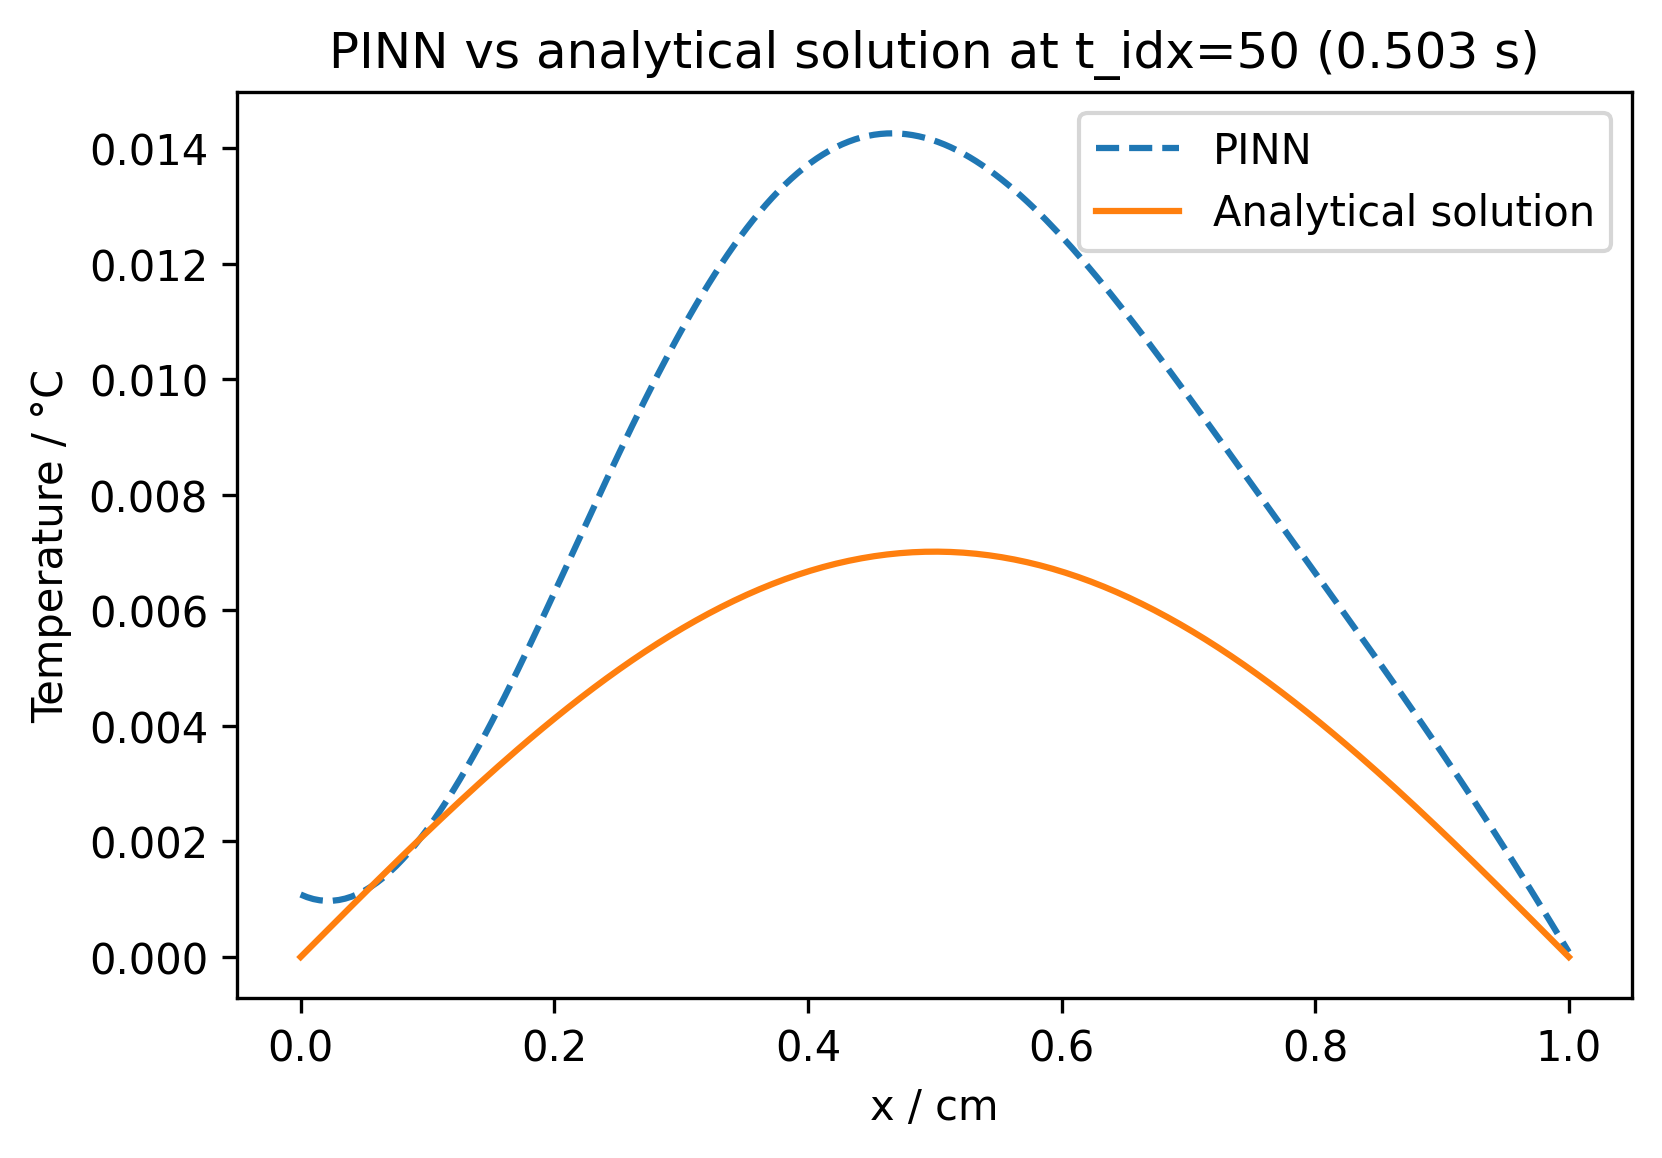

MAE: 0.003557628013828194
MSE: 1.8883112712237176e-05
Relative error (%): 87.81470569352014


In [17]:
# PINN vs analytical solution at t_idx = 50
plt.plot(x, H_pred[50,:], '--')
plt.plot(x, U[50,:], '-')
plt.title('PINN vs analytical solution at t_idx=50 ({} s)'.format(round(t[50],3)))
plt.legend(['PINN', 'Analytical solution'])
plt.xlabel('x / cm')
plt.ylabel('Temperature / °C')
plt.show()

mae = np.sum(np.abs(H_pred[50,:]- U[50,:]).mean(axis=None))
print('MAE:', mae)

mse = ((U[50,:] - H_pred[50,:])**2).mean(axis=None)
print('MSE:', mse)

rel_error = np.linalg.norm(H_pred[50,:]- U[50,:]) / np.linalg.norm(U[50,:])
print('Relative error (%):', rel_error*100)

In [18]:
round(t[50],3)

0.503

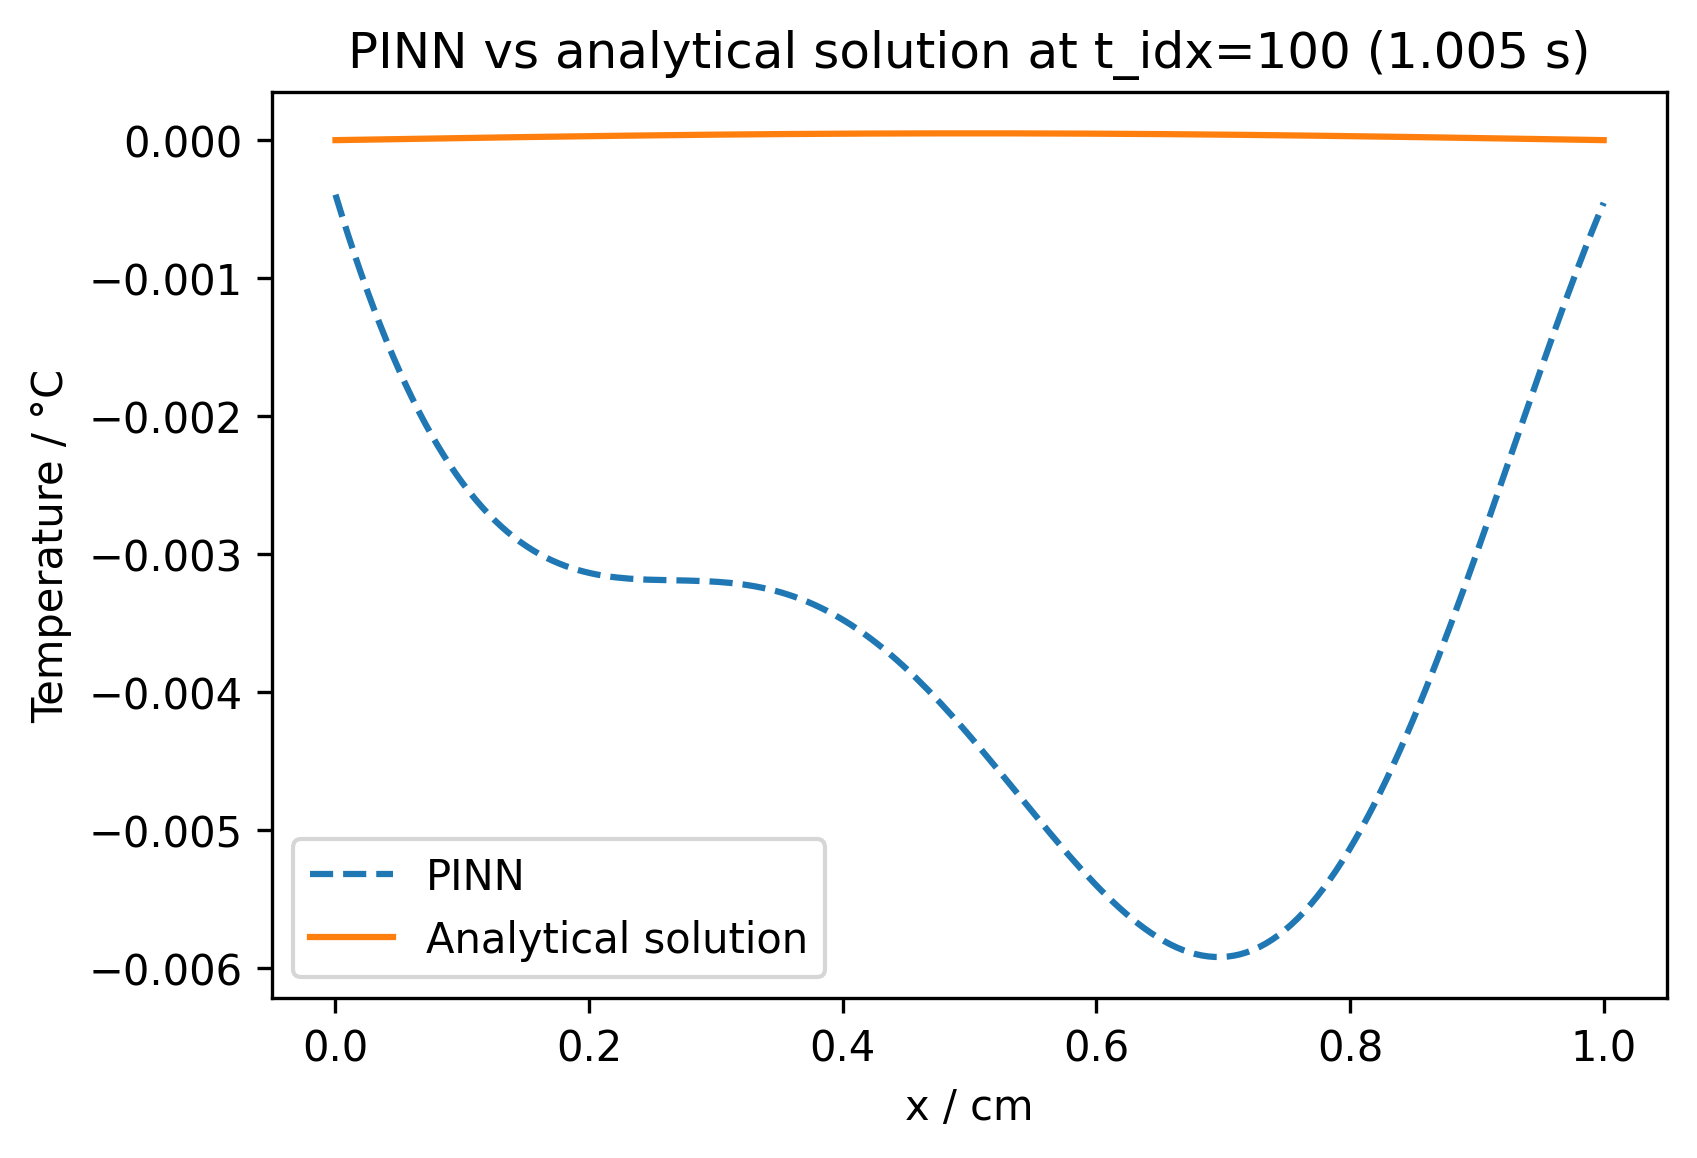

MAE: 0.003708091490541812
MSE: 1.5902017520972786e-05
Relative error (%): 11486.390352856895


In [19]:
# PINN vs analytical solution at t_idx = 100
plt.plot(x, H_pred[100,:], '--')
plt.plot(x, U[100,:], '-')
plt.title('PINN vs analytical solution at t_idx=100 ({} s)'.format(round(t[100],3)))
plt.legend(['PINN', 'Analytical solution'])
plt.xlabel('x / cm')
plt.ylabel('Temperature / °C')
plt.show()

mae = np.sum(np.abs(H_pred[100,:]- U[100,:]).mean(axis=None))
print('MAE:', mae)

mse = ((U[100,:] - H_pred[100,:])**2).mean(axis=None)
print('MSE:', mse)

rel_error = np.linalg.norm(H_pred[100,:]- U[100,:]) / np.linalg.norm(U[100,:])
print('Relative error (%):', rel_error*100)

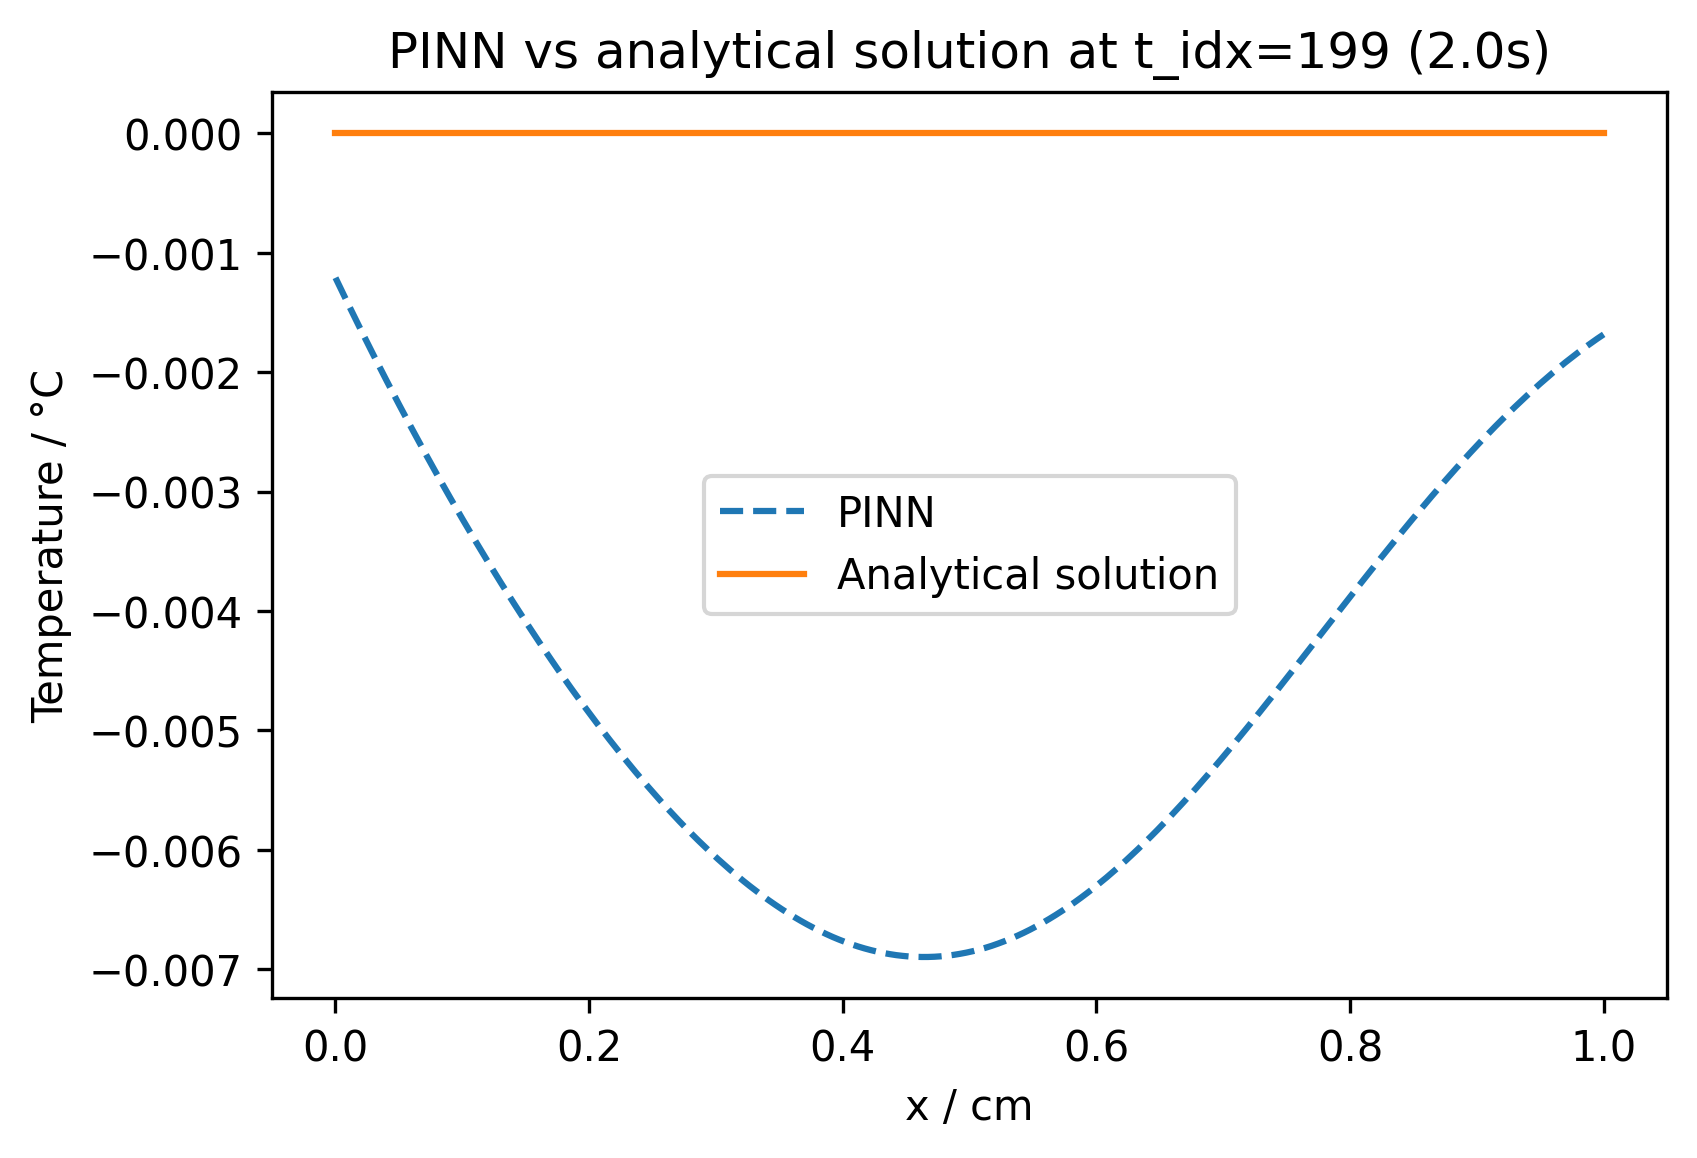

MAE: 0.004730269107550859
MSE: 2.5392919105513045e-05
Relative error (%): 267047939.8558801


In [20]:
# PINN vs analytical solution at t_idx=199
plt.plot(x, H_pred[199,:], '--')
plt.plot(x, U[199,:], '-')
plt.title('PINN vs analytical solution at t_idx=199 ({}s)'.format(round(t[199],3)))
plt.legend(['PINN', 'Analytical solution'])
plt.xlabel('x / cm')
plt.ylabel('Temperature / °C')
plt.show()

mae = np.sum(np.abs(H_pred[199,:]- U[199,:]).mean(axis=None))
print('MAE:', mae)

mse = ((U[199,:] - H_pred[199,:])**2).mean(axis=None)
print('MSE:', mse)

rel_error = np.linalg.norm(H_pred[199,:]- U[199,:]) / np.linalg.norm(U[199,:])
print('Relative error (%):', rel_error*100)

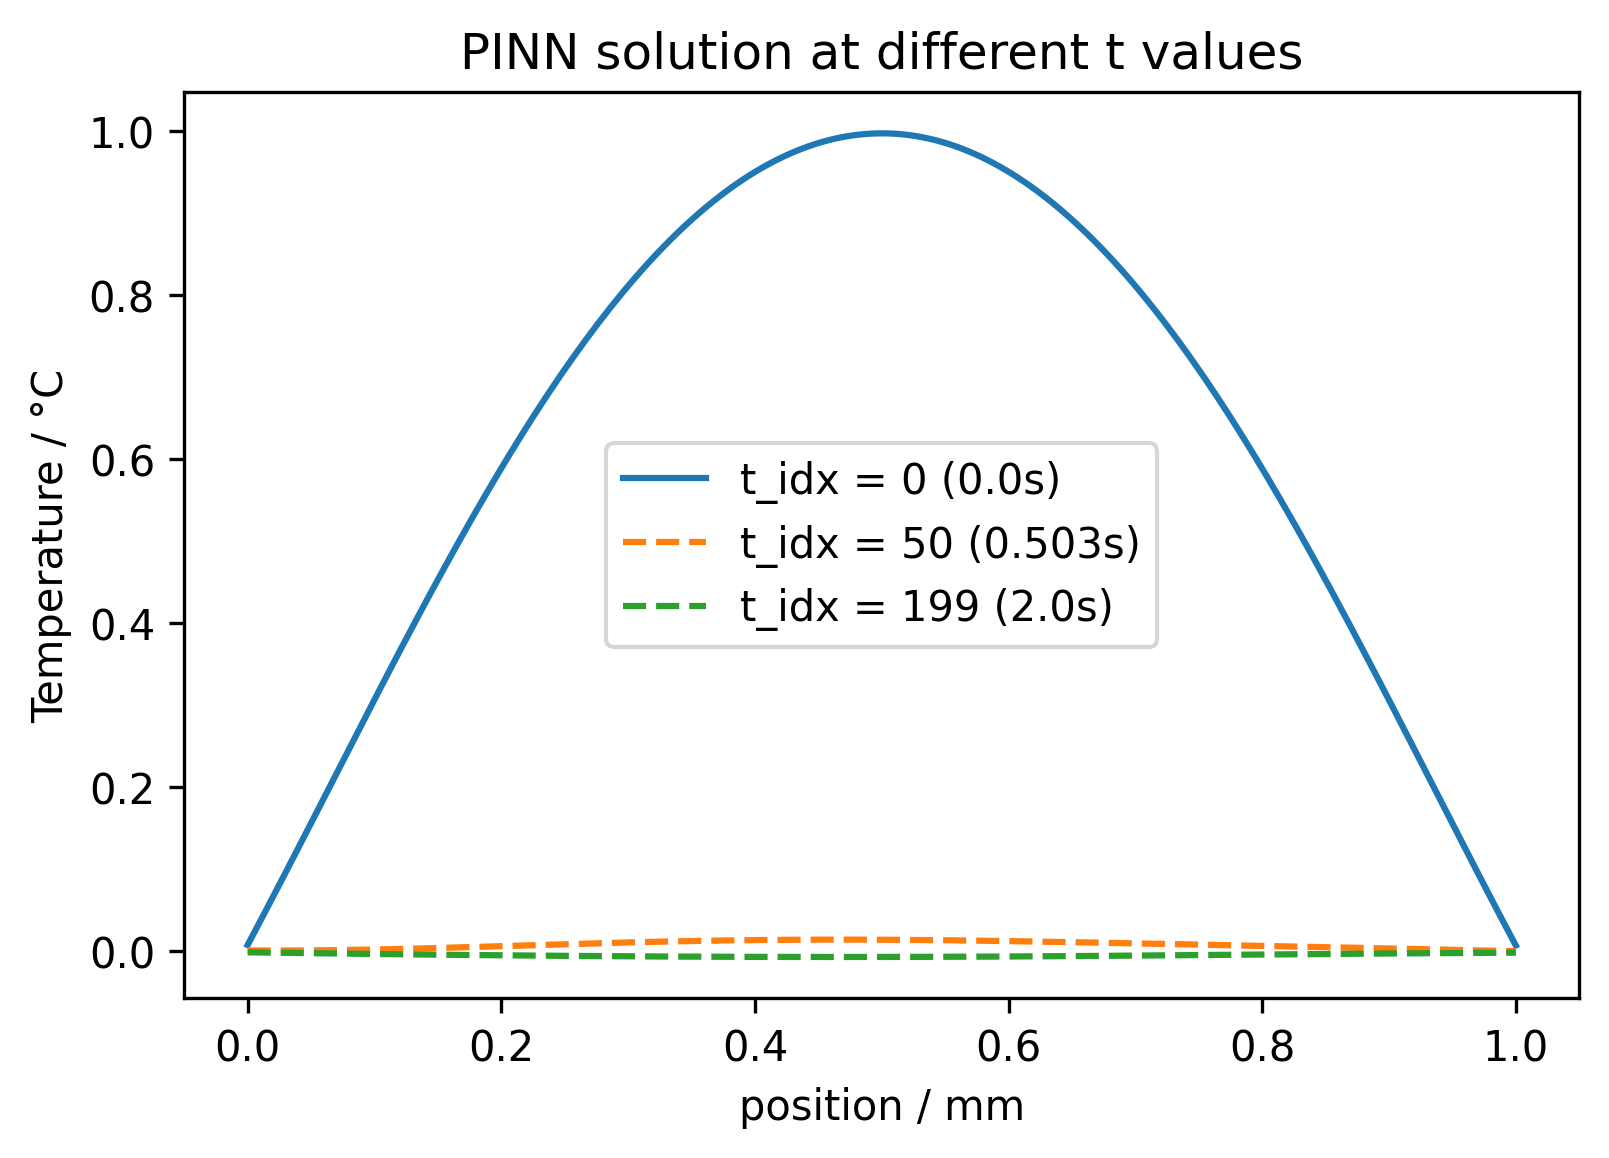

In [21]:
# PINN results at different time points
plt.plot(x, H_pred[0,:], '-')
plt.plot(x, H_pred[50,:], '--')
plt.plot(x, H_pred[199,:], '--')
plt.title('PINN solution at different t values')
plt.legend(['t_idx = 0 ({}s)'.format(t[0]),'t_idx = 50 ({}s)'.format(round(t[50],3)), 't_idx = 199 ({}s)'.format(t[199])])
plt.xlabel('position / mm')
plt.ylabel('Temperature / °C')
#plt.legend(loc='upper right')
plt.show()

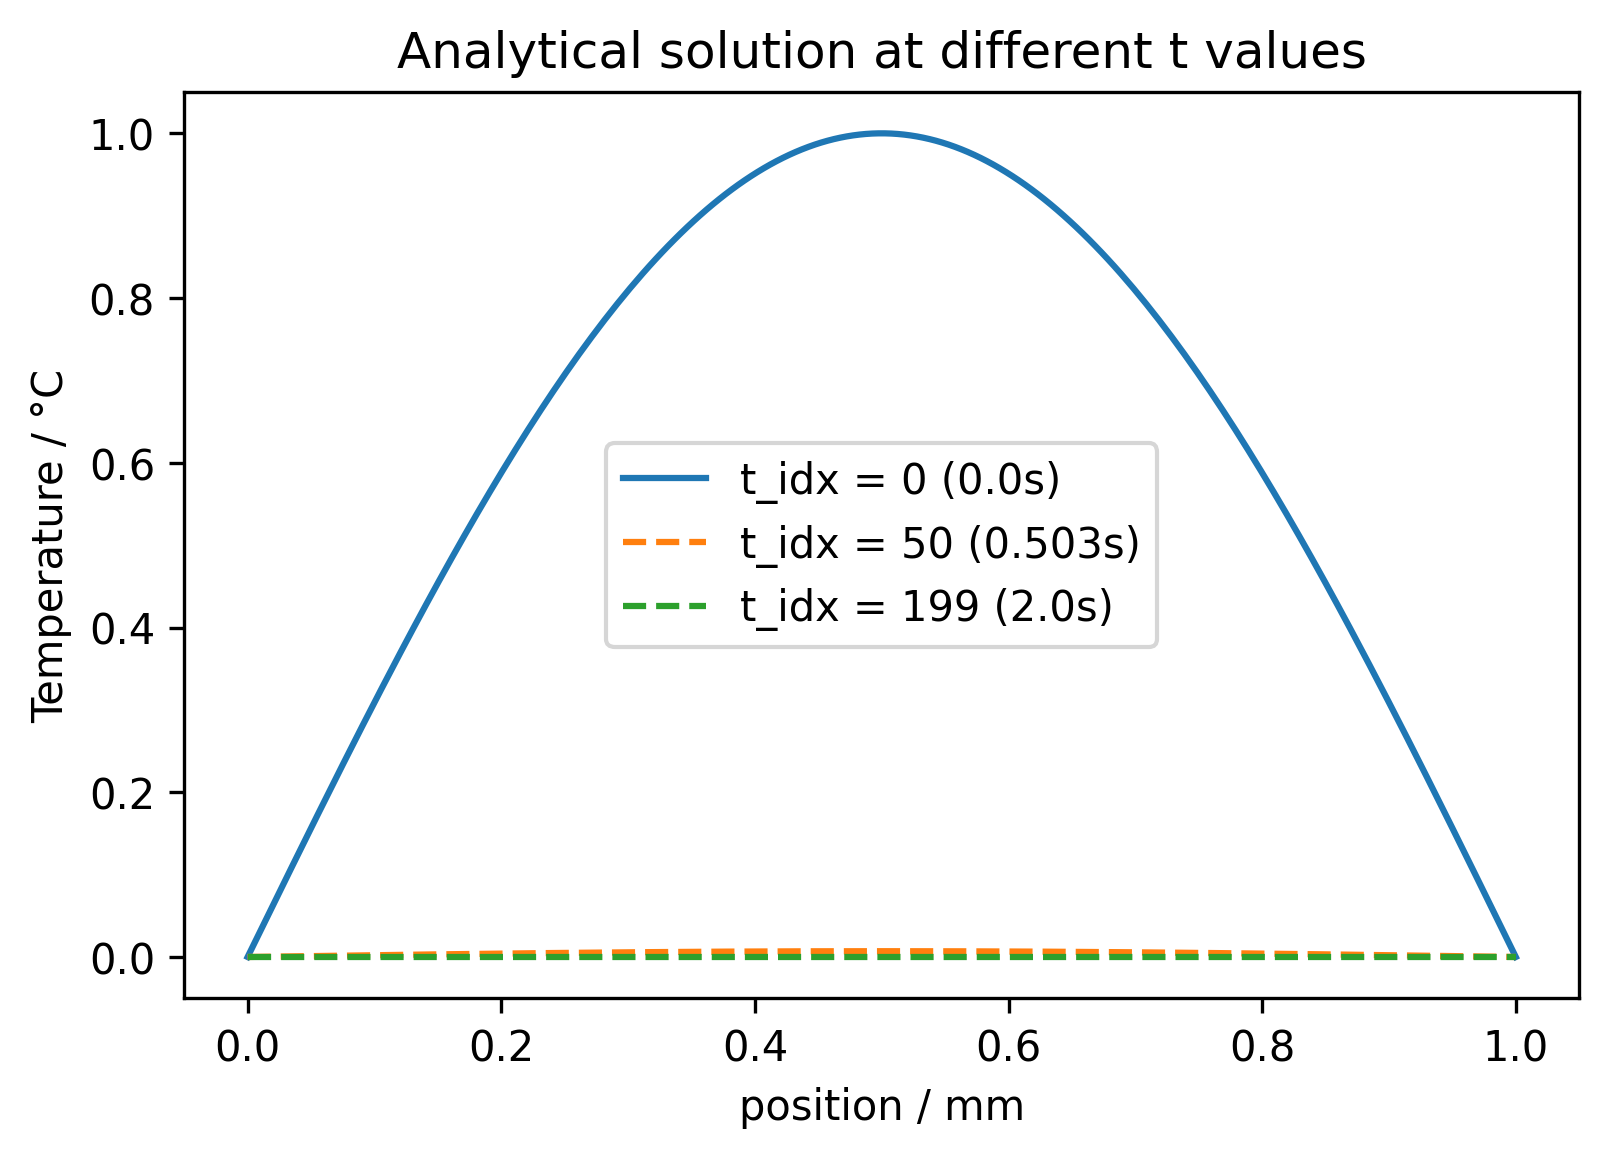

In [22]:
# Analytical solution at different time points
plt.plot(x, U[0,:], '-')
plt.plot(x, U[50,:], '--')
plt.plot(x, U[199,:], '--')
plt.title('Analytical solution at different t values')
plt.legend(['t_idx = 0 ({}s)'.format(t[0]),'t_idx = 50 ({}s)'.format(round(t[50],3)), 't_idx = 199 ({}s)'.format(t[199])])
plt.xlabel('position / mm')
plt.ylabel('Temperature / °C')
plt.show()